# Fibonacci States

ZPGenerator is designed to simulate sources of light that require complicated pulse sequences to produce the photonic state. To demonstrate this capability, this example explores constructing and simulating a source of entangled photonic Fibonacci states that were first proposed and demonstrated in a Quandela research paper [[S. C. Wein et al., Nature Photonics 16, 374–379 (2022)](https://www.nature.com/articles/s41566-022-00979-z)].

## Theory background

Two-level atoms, or artificial atoms such as quantum dots, have been widely studied as a source of single photons. To deterministically generate entangled states of light, usually we must turn to sources of light based on multi-level systems, such as charged exciton containing the trion state (see the [Quantum Dots](quantum_dots.ipynb) and [Entanglement Generation](entanglement_generation.ipynb) tutorials). Surprisingly, a two-level system composed of a ground state $|g\rangle$ and an excited state $|e\rangle$ _can_ be used to deterministically generate entangled states of light encoded in the photon-number basis. This relies on the fact that the interaction between a two-level system and the electromagnetic field is essentially an entangling gate that preserves quantum coherence [[J. C. Loredo et al., Nature Photonics 13, 803–808 (2019)](https://www.nature.com/articles/s41566-019-0506-3)].

The basic idea is to apply a sequence of well-timed excitation pulses to re-excite the atom before it has had time to fully decay. These excitation pulses play the role of single-qubit bit-flip gates on an ancillary qubit (the source) that is used to entangled the electromagnetic field. The photonic qubits are then the occupation of time bin modes defined between each subsequent pulse.

As an example, the state of the source after a single $\pi$ pulse is $|e\rangle$. After a delay exactly equal to the atomic half-life $\tau = T_1\ln(2)$ where $T_1$ is the source lifetime, the atom may or may not have emitted a photon. Since the light-matter interaction is coherent, the total source-field system enters into an entangled state $|\Psi\rangle = (|e\rangle|0\rangle + |g\rangle|1\rangle)/\sqrt{2}$. If, at this moment, we apply a second $\pi$ pulse, the state of the source is flipped and the total light-matter state becomes $|\Psi\rangle = (|g\rangle|0\rangle + |e\rangle|1\rangle)/\sqrt{2}$. Now, if we let the atom finish decaying to the ground state, we are left with the separable state $|\Psi\rangle = |g\rangle|\psi\rangle$ where the state of the light is a maximally entangled Bell state $|\psi\rangle = (|00\rangle + |11\rangle)/\sqrt{2}$.

This idea can be extended to $N$ $\pi$ pulses where each subsequent pulse adds a qubit to the state of light. It turns out that the delay between each pulse that maximises the entanglement in the state of light are determined by the Fibonacci sequence:
\begin{equation}
\tau_i = T_1\ln\left(\frac{F_{N+2-i}}{F_{N-i}}\right)
\end{equation}
where $F_i = F_{i-1}+F_{i-2}$, $F_{0} = 0$, and $F_{1}=1$. Applying a pulse sequence based on this pattern will produce a sequence of entangled states that are expressed as an equally-weighted superposition of $F_N$ basis states:
    
$$
\begin{aligned}
    |\psi_0\rangle &= |0\rangle\\
    |\psi_1\rangle &= |1\rangle\\
    |\psi_2\rangle &= \left(|00\rangle+|11\rangle\right)/\sqrt{2}\\
    |\psi_3\rangle &= \left(|001\rangle+|100\rangle+|111\rangle\right)/\sqrt{3}\\
    |\psi_4\rangle &= \left(|0000\rangle+|0011\rangle+|1001\rangle+|1100\rangle+|1111\rangle\right)/\sqrt{5}\\
    &\vdots
\end{aligned}
$$
    
We can also notice that $|\psi_N\rangle$ is a superposition state of photon number states with the same parity as $N$. Either $N$ is odd and $|\psi_N\rangle$ is a superposition of odd-numbers of photons or $N$ is even and $|\psi_N\rangle$ is a superposition of even-numbers of photons. Furthermore, the number of states composing $|\psi_N\rangle$ with the same total number of photons will follow Pascal's triangle:

<div>
<img src="../_static/img/pascals_triangle.png" width="500"/>
</div>

## Fibonacci pulse sequence

To test our theory and replicate some experimental results, we can define a Fibonacci pulse sequence and simulate photon statistics using ZPGenerator.

In [32]:
from zpgenerator import *
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt

First, we define a function to generate the Fibonacci sequence. In this case, we can take the answer to [this Stack Overflow question](https://stackoverflow.com/questions/4935957/fibonacci-numbers-with-an-one-liner-in-python-3).

In [33]:
def fibonacci(n: int) -> int:
    return reduce(lambda x, n: [x[1], x[0] + x[1]], range(n), [0, 1])[0]

Second, we can make a function that generates a list of delay times $\tau_i$ defined in the previous section.

In [34]:
def fibonacci_delays(N: int) -> list:
    delays = [0.]  # initialise the list of pulse delay times starting with the initial time of 0.
    
    # Loop through each pulse and add up the delay, append to the list
    for i in range(1, N):
        delay = np.log(fibonacci(N - i + 2) / fibonacci(N - i))  # tau_i in units of T1
        delays.append(delays[-1] + delay)
        
    return delays

Third, we can use the Pulse class to define a function that builds a sequence of $N$ $\pi$ pulses separated by the delay $\tau_i$ defined in the previous section.

In [35]:
def fibonacci_sequence(N: int,  # the number of pulses
                       shape: str = 'dirac',  # dirac, gaussian, or square.
                       width: float = 0.1  # the pulse width (irrelevant for dirac) in units of T1.
                      ) -> Pulse:
    sequence = Pulse()  # initialise the pulse object

    delays = fibonacci_delays(N)  # generate the list of pulse times

    for i in range(0, N):  # loop over each pulse and add it to our sequence

        # define the new pulse we want to add
        pulse_shape = Pulse.square if shape == 'square' else Pulse.gaussian if shape == 'gaussian' else Pulse.dirac
        pulse = pulse_shape({'delay': delays[i], 'area': np.pi, 'width': width}, name='pulse ' + str(i))

        sequence.add(pulse)  # we add the pulse to our sequence

    return sequence

To get a quick idea of what our pulse sequence looks like, we can use the plot() method. Note that, by default, evaluating a pulse shape will ignore any Dirac pulses.

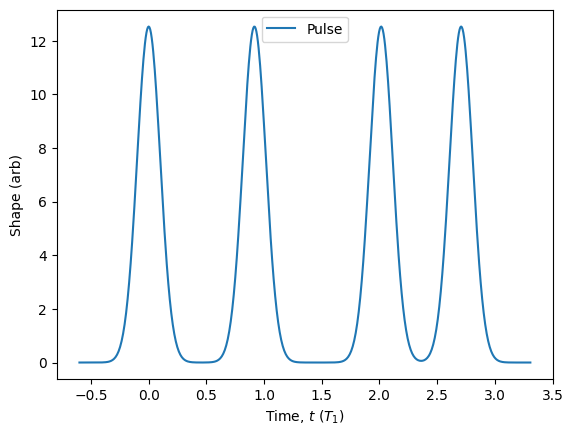

In [36]:
sequence = fibonacci_sequence(4, shape = 'gaussian', width=0.1)  # define our sequence
sequence.plot().show()

Note that we can always change the pulse parameters afterward making analysis easy!

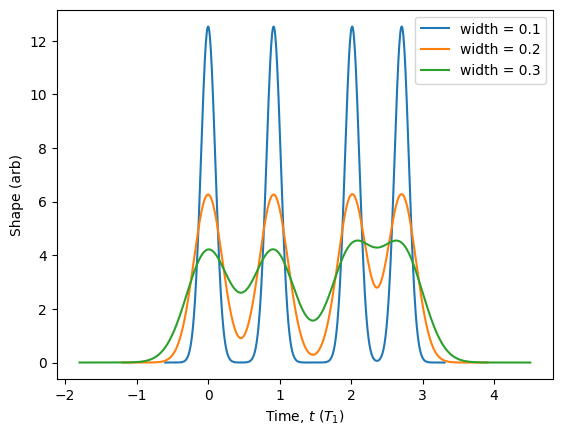

In [37]:
sequence.plot(parameters={'width': 0.1}, label='width = 0.1')
sequence.plot(parameters={'width': 0.2}, label='width = 0.2')
sequence.plot(parameters={'width': 0.3}, label='width = 0.3').show()

Since we named each pulse in the sequence, we can also modify the pulse parameters individually.

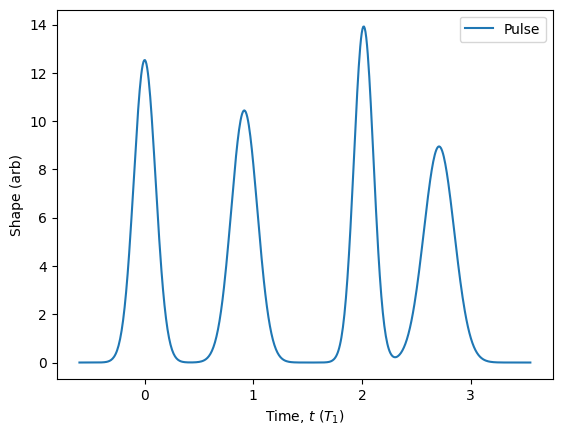

In [38]:
sequence.plot(parameters={'pulse 0/width': 0.10, 'pulse/area 0': np.pi/2,
                          'pulse 1/width': 0.12,
                          'pulse 2/width': 0.09,
                          'pulse 3/width': 0.14}).show()

## Fibonacci source

Now that we have our pulse sequence, we must build our source by applying the sequence to generate photons.

In [39]:
source = Source.two_level(pulse=sequence)

Once we defined our source, we can simulate various figures of merit. One of the first things to look at is the source "lifetime", which is the instantaneous probability that the two-level system is in its excited state. This quantity is proportional to the shape of the emitted photonic wavepacket. For visualisation, let's use a Gaussian pulse shape.

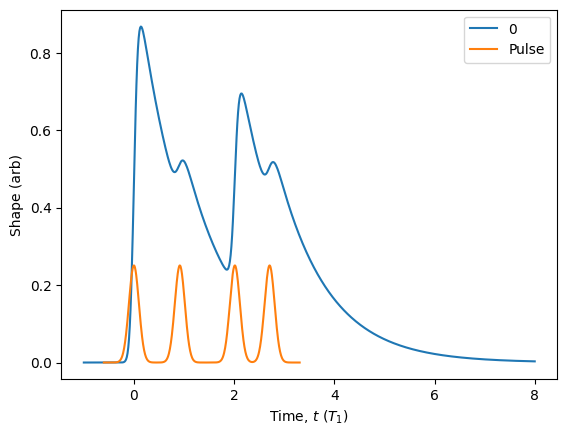

In [40]:
# Evaluate the source lifetime between t = -1 and t = 8 for 600 points.
source.plot_lifetime(start = -1, end = 8, resolution = 600)
sequence.plot(scale=1/50).show()

Now that we have verified our source emission intensity looks consistent with our applied pulse sequence, let's look at the photon statistics. To make things simpler, let's make a function that returns a Fibonacci source.

In [41]:
def fibonacci_source(N: int,  # the number of pulses
                     shape: str = 'dirac',  # dirac, gaussian, or square.
                     width: float = 0.1,  # the pulse width (irrelevant for dirac) in units of T1.
                     efficiency: float = 1.  # the efficiency of collecting a photon from the source.
                     ) -> Source:
    return Source.two_level(pulse=fibonacci_sequence(N, shape, width), efficiency=efficiency)

Let's continue on by first analysing the ideal case where we use Dirac $\pi$ pulses to compare to our theory. Using the photon_statistics() method, we can automatically and efficiently compute the total integrated photon statistics produced over the entire wavepacket lifetime.

In [42]:
source = fibonacci_source(4, shape='dirac')
pn = source.photon_statistics()
pn.display_figures()
pn.display()

Figure of Merit       | Value
Brightness            | 0.8000
Average photon number | 2.0000
Intensity correlation | 0.9000

Number  | Probability
0       | 0.20000
1       | 0.00000
2       | 0.60000
3       | 0.00000
4       | 0.20000
5       | 0.00000
6       | 0.00000



We can see that the average number of photons (mu $=\mu$ ) produced by our source per excitation pulse sequence is $2$. The source brightness (beta $=\beta$), which is the probability of producing at least one photon per excitation pulse sequence, is $0.8$. The integrated intensity correlation (g2 $= g^{(2)}$), which characterises the amount of multi-photon emission, is $0.9$. These figures of merit seem to be almost classical in nature, but in fact the photon number probabilities show very clearly that the photonic state produced by our source is not at all a coherent state. As predicted in the Theory background section, we see non-zero probabilities only for even numbers of photons, which is the same parity as the number of pulses that we applied. Furthermore, we can see that $1/5$ of the time we measure no photons, $3/5$ of the time we measure two photons and the remaining $1/5$ of the time we measure four photons. This 1, 3, 1 pattern follows the shallow diagonal of Pascale's triangle shown in the Theory background section for $|\psi_4\rangle$.

To demonstrate how fast ZPGenerator is for computing integrated photon number probabilities, let's take a quick look at the photon distribution of the $|\psi_{40}\rangle$ and $|\psi_{41}\rangle$ Fibonacci states. Note that, these highly-entangled photonic states live in a total Hilbert space of up to $2^{41}=2.2$ trillion in size. However, since we are only obtaining the integrated (averaged) photon number statistics of the state, the simulation can be performed in polynomial time using the ZPG method.

In [43]:
source = fibonacci_source(40, shape='dirac')
psi40 = source.photon_statistics(truncation=40)

source = fibonacci_source(41, shape='dirac')
psi41 = source.photon_statistics(truncation=41)

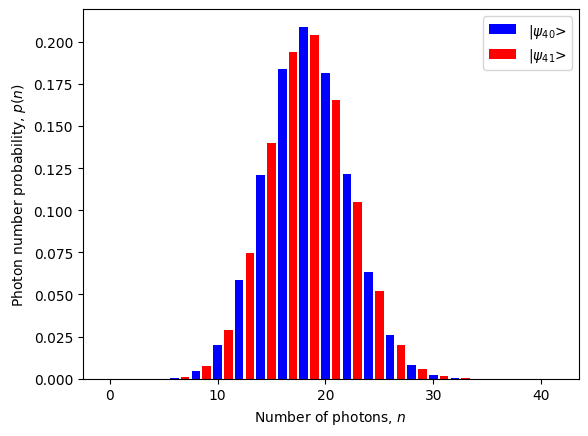

In [44]:
psi40.plot(label='|$\psi_{40}$>', color='b')
psi41.plot(label='|$\psi_{41}$>', color='r').show()

In the above plot, we can see clearly that for $N=40$, only even-$n$ probabilities are nonzero. Likewise for $N=41$, only odd-$n$ probabilities are nonzero. Interestingly, the shape of the distribution when neglecting the parity, follows a Gaussian distribution.

To be sure that we are generating states with individual qubits occupying the time bin modes, and not just a single mode with an interesting photon-number distribution, we must resolve the possible Fock states contributing to the total Fibonacci state. For $|\psi_4\rangle$, this means we must resolve the three states: $|0011\rangle$, $|1001\rangle$, and $|1100\rangle$ that contribute to the two-photon subspace. To do this, we can measure time-bin correlations.

<h2 align="center"><font color='black'>4. Time Bin Correlations </font><a class="anchor" id="4"></h2>

Once we have designed our source, we can monitor its emission into different time bins using the Processor class to add detectors explicitly. In this case, we have a very simple Processor composed of a single mode collecting emission from our Fibonacci source, an identity linear-optical circuit, but a more complex set of time bin detectors counting photons in defined time bins. Since we already built our source in the previous sections, let's build a detector that partitions time following the same time bin thresholds that we used to define the pulse sequence. This kind of time-bin partitioned detector can easily be created using the partition() class method of Detector. See [Detectors](detectors.ipynb) for more information about this catalogue detector type.

In [45]:
def fibonacci_detector(pulse_number: int):
    return Detector.partition(thresholds=fibonacci_delays(pulse_number), name='fibo')

Now, let's add it to a processor following the Fibonacci source.

In [46]:
pulse_number = 4
p = Processor() // fibonacci_source(pulse_number) // fibonacci_detector(pulse_number)
p.display()


        _____________
|0>----|  Component  |----D~ [fibo bin 0, fibo bin 1, fibo bin 2, fibo bin 3]
        ‾‾‾‾‾‾‾‾‾‾‾‾‾


Using the display() method, we can see that our processor is composed of a single source with emission collected into a single mode, and monitored by a single detector. However, there are 4 detection bins associated with the detector. Note that we can always check how many measurement bins the processor contains by looking at the 'bins' property.

In [47]:
p.bins

4

Let's take a look at the probabilities for detecting photons across these four time bins.

In [48]:
pn = p.probs()
pn.display()

Pattern | Probability
0 0 0 0 | 0.20000
0 0 1 1 | 0.20000
1 0 0 1 | 0.20000
1 1 0 0 | 0.20000
1 1 1 1 | 0.20000



As predicted in the Theory background section, we can now resolve all five possible outcomes of our Fibonacci source, and they each occur with $1/5$ probability! As a general rule, the outcome labels of Processor give the photon number listed chronologically from left to right for each detection time bin. Luckily, we assigned a name to our time partition detector, which labels each bin chronologically, so we can always double-check the ordering by looking at the 'bin_labels' property of the processor.

In [49]:
p.bin_labels

['fibo bin 0', 'fibo bin 1', 'fibo bin 2', 'fibo bin 3']

## Interference

Now that we have confirmed our source produces the correct photon statistics, we should also ensure that we have coherence between Fock states. To do this, we can follow the method used in [[S. C. Wein et al., Nature Photonics 16, 374–379 (2022)](https://www.nature.com/articles/s41566-022-00979-z)] to characterise the $N=2$ Bell state using Hong-Ou-Mandel interference and measuring the second-order number coherence ($c^{(2)}$) between $|00\rangle$ and $|11\rangle$. Using ZPGenerator, we can make quick estimates of figures of merit obtained from Hong-Ou-Mandel interference using the hom() method of the Processor class. Since we only want to view these figures of merit, let's use the display_hom() method, which computes hom() and then displays the results.

In [50]:
p = Processor() // fibonacci_source(2)
p.display_hom(pseudo_limit=0.005)

Figure of Merit                | Value
First order number coherence   | 0.0013
Second order number coherence  | 0.5076
Hong-Ou-Mandel visibility      | -0.5176
Mean wavepacket overlap        | 0.4850



The hom() method applies a pseudo-lossy regime algorithm using threshold detectors and so, although it is fast to evaluate, it can be quite sensitive to the 'pseudo_limit' efficiency regime parameter. For an appropriate choice of pseudo_limit, we can see that ZPGenerator predicts very close to the ideal values expected from the ideal Bell state in [[S. C. Wein et al., Nature Photonics 16, 374–379 (2022)](https://www.nature.com/articles/s41566-022-00979-z)]. That is, we get $c^{(2)}\simeq 1/2$, $c^{(1)}\simeq 0$, and $V_\text{HOM}= M - g^{(2)} \simeq -1/2$ implying $M\simeq 1/2$. To do better than this quick estimation algorithm, we can manually build a Hong-Ou-Mandel processor and do our own virtual experiment using photon-number resolving detectors.

In [51]:
def fibonacci_hom(phase: float = 0, shape: str = 'dirac', width: float = 0.1, efficiency: float = 1.) -> Processor:
    p = Processor()  # initialise a processor with two modes
    
    p.add([0, 1], fibonacci_source(2, shape, width, efficiency))  # add an N=2 Fibonacci source to modes 0 and 1
    p.add(0, Circuit.ps(phase))  # add a phase shifter on mode 0 to tune the relate phases of the interfering photonic states
    p.add(0, Circuit.bs())  # add the beam splitter to perform Hong-Ou-Mandel interference
    p.add(0, Detector.pnr(4), bin_name='output 0')  # Add number resolving detectors monitoring output modes with maximum resolution of 4
    p.add(1, Detector.pnr(4), bin_name='output 1')
    
    return p

Now that we have built our Hong-Ou-Mandel processor, we can take a look at the probabilities from interference when there is no relative phase between our input states. Note that, in this case, our detectors are not time bin arrays, so we will look at the time-integrated properties of our state.

In [52]:
p = fibonacci_hom(0)
p.probs().display()

Pattern | Probability
0 0     | 0.25000
4 0     | 0.06250
1 1     | 0.50000
2 2     | 0.12500
0 4     | 0.06250



The outcomes of a Processor are automatically arranged in chronological order based on the initial time of each detection time bin. If two bins share the same initial time, as in this case, they will be arranged according to the order that the detectors were added to the processor. Since we named our arrays based on the output port they were added to, we can double-check the ordering by looking at the bin_labels properties of our Processor.

In [53]:
print('Bin labels: ', p.bin_labels)

Bin labels:  ['output 0', 'output 1']


To get a better estimate of the second-order coherence $c^{(2)}$, we can look at how the two-photon coincidence (1, 1) depends on the relative phase of the input states. Note that this type of exact numerical simulation would usually take an extremely long time to compute, because it requires simulating conditional time evolution of source states in the tensor product space of two source Hilbert spaces, evaluating $4^2 = 16$ possible detection outcomes for two detectors each resolving up to 4 photons, and then again for multiple different measurement configurations of our linear-optical circuit. Standard time-integration techniques would require recursive integration over multi-time correlation functions up to 8 dimensions in time. Using the ZPG method, however, we bypass this high-dimensional integration such that the simulation takes only a handful of seconds.

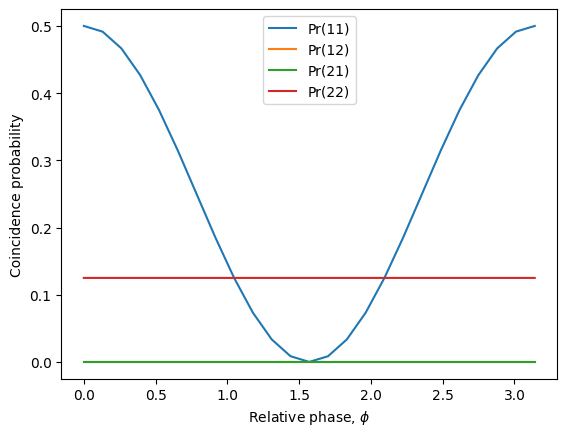

In [54]:
phases = np.linspace(0, np.pi, 25)  # define some phases
probs = [fibonacci_hom(phi).probs() for phi in phases]  # evaluate the HOM probabilities for each phase

# Let's extract coincidence probabilities only
coinc_labels = [(1, 1), (1, 2), (2, 1), (2, 2)]
coinc = [[pr[c] for c in coinc_labels] for pr in probs]

# Plot each coincidence event
for i, c in enumerate(coinc_labels):
    plt.plot(phases, list(zip(*coinc))[i], label='Pr(' + ''.join([str(n) for n in c]) + ')')

plt.xlabel('Relative phase, $\phi$')
plt.ylabel('Coincidence probability')
plt.legend(loc='upper center')
plt.show()

As expected, we can see a clear fringe in the two-photon (1, 1) coincidence events due to interference between the vacuum of one input state and the two-photon state of the other, indicating coherence. On the other hand, the four-photon outcomes shows no such fringe, which is expected because there is only one possible input state combination giving rise to that outcome for a $|\psi_2\rangle$ state. Also, we can see that we never observe odd photon number coincidence events because our source is producing an even Fibonacci state!

The value of $c^{(2)}$ can now be directly determined by taking the difference in the coincidence intensity at the minimum and maximum of the fringe, and then normalising by the squared average photon number of our source: $c^{(2)} = \frac{1}{\mu^2}\sum_{n,m}nm|Pr_{\phi=0}(nm) - Pr_{\phi=\pi/2}(nm)|$. Using either $\mu=1$ from before or $\mu=\frac{1}{2}\sum_{n,m}(n+m)Pr(nm)$, we can confirm $c^{(2)}=\frac{1}{2}$ which, along with verifying that our source is indeed producing a photon-number Bell state.

In [55]:
def c2(shape: str = 'dirac', width: float = 0.1, efficiency: float = 1., args: dict = None) -> float:
    # Simulate HOM for max and min of the fringe
    probs0 = fibonacci_hom(0, shape, width, efficiency).probs(args)
    probs1 = fibonacci_hom(np.pi/2, shape, width, efficiency).probs(args)
    
    # Estimate mu from half the average photon number of both ouputs
    mu = sum((int(k[0]) + int(k[1]))*pr for k, pr in probs0.items())/2
    
    # Compute c2
    return sum(int(k[0])*int(k[1])*abs(probs0[k] - probs1[k]) for k in probs0.keys())/mu**2

print(c2())

0.5000022420571637


## Imperfections

In reality, we are not able to apply perfect Dirac pulses to our emitter and our setup may not have perfect collection or detection efficiency. ZPGenerator is designed to take many physical imperfections into account in a natural way. To study imperfections, we can make a function that simulates the classical Bhattacharyya coefficient. This coefficient is an upper bound on the quantum state fidelity.

In [56]:
def bhatt_fidelity(N: int,  # the number of pulses
                   shape: str = 'dirac',  # dirac, gaussian, or square.
                   width: float = 0.1,  # the pulse width (irrelevant for dirac) in units of T1.
                   efficiency: float = 1.  # the end-to-end efficiency
                  ):

    # First, we simulate the ideal case as before
    p = Processor() // fibonacci_source(N) // fibonacci_detector(N)
    ideal_probs = p.probs()
    
    # next, we simulate the imperfect case
    p = Processor() // fibonacci_source(N, shape=shape, width=width, efficiency=efficiency) // fibonacci_detector(N)
    probs = p.probs()

    # we estimate an upper bound on the quantum state fidelity using squared classical Bhattacharyya coefficient
    bhatt = 0
    for k, v in ideal_probs.items():
        bhatt += np.sqrt(v * probs[k]) if k in probs.keys() else 0

    return bhatt ** 2

Using this function, we can increase the Gaussian pulse width and see how the fidelity bound decreases.

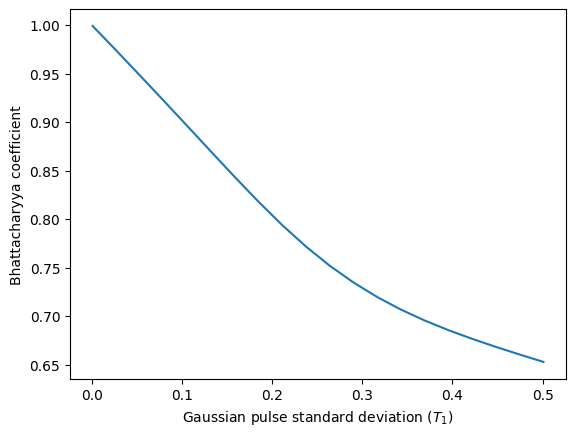

In [57]:
pulse_widths = np.linspace(0.001, 0.501, 20)

fidelity_set = [bhatt_fidelity(4, shape='gaussian', width=width) for width in pulse_widths]

plt.plot(pulse_widths, fidelity_set)
plt.xlabel("Gaussian pulse standard deviation ($T_1$)")
plt.ylabel("Bhattacharyya coefficient")
plt.show()

Similarly, we can see how inefficiency decreases the fidelity bound even using perfect pulses.

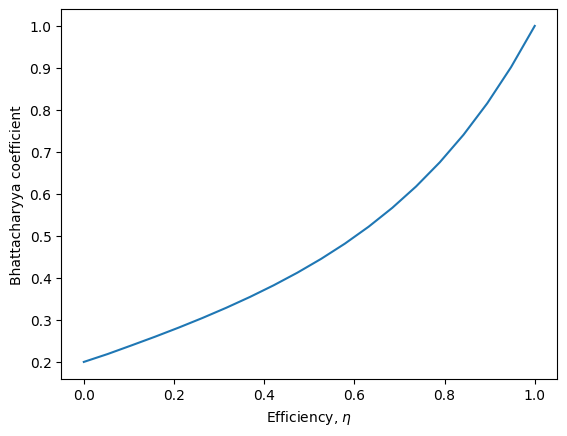

In [58]:
efficiency_set = np.linspace(0, 1, 20)

fidelity_set = [bhatt_fidelity(4, shape='dirac', efficiency=efficiency) for efficiency in efficiency_set]

plt.plot(efficiency_set, fidelity_set)
plt.xlabel("Efficiency, $\eta$")
plt.ylabel("Bhattacharyya coefficient")
plt.show()